In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import xarray as xr
import pandas as pd
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import os
from datetime import timedelta

In [27]:
import bsose.preprocess as pp

In [28]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4_3D, ErrorCode, Variable

### Define FieldSet

In [29]:
rootdir = "/local/data/bSOSE/iter133NEW/5day/"
filenames = {'U':rootdir+'bsose_i133_2013to2018_5day_Uvel.nc',
             'V':rootdir+'bsose_i133_2013to2018_5day_Vvel.nc',
             'W':rootdir+'bsose_i133_2013to2018_5day_Wvel.nc',
             'T':rootdir+'bsose_i133_2013to2018_5day_Theta.nc',
             'S':rootdir+'bsose_i133_2013to2018_5day_Salt.nc'}
variables = {'U': 'UVEL',
             'V': 'VVEL',
             'W': 'WVEL',
             'T': 'THETA',
             'S': 'SALT'}
dimensions = {'U':{'lon':'XG','lat':'YC','depth':'Z','time':'time'},
             'V':{'lon':'XC','lat':'YG','depth':'Z','time':'time'},
             'W':{'lon':'XC','lat':'YC','depth':'Zl','time':'time'},
             'T':{'lon':'XC','lat':'YC','depth':'Z','time':'time'},
             'S':{'lon':'XC','lat':'YC','depth':'Z','time':'time'}}
fs = FieldSet.from_netcdf(filenames,variables,dimensions,
                          deferred_load=True,gridindexingtype='mitgcm',
                          time_periodic=timedelta(days=30*365))

# Add conditions for periodic boundary
fs.add_constant('halo_west', fs.U.grid.lon[0])
fs.add_constant('halo_east', fs.U.grid.lon[-1])
fs.add_periodic_halo(zonal=True)

def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west

In [30]:
# Pick up T and S
class TSParticle(JITParticle):
    T = Variable('T', dtype=np.float32)
    S = Variable('S', dtype=np.float32)

def SampleTS(particle, fieldset, time):
    particle.T = fieldset.T[time,
                            particle.depth,
                            particle.lat,
                            particle.lon]
    particle.S = fieldset.S[time,
                            particle.depth,
                            particle.lat,
                            particle.lon]

In [43]:
N = 50
# Drake Passage
lats1D = np.linspace(-75,-55,N)
lons1D=(291-10)#*np.ones(N)
depths1D=-1*np.linspace(200,3000,N)
[lons,lats,depths] = np.meshgrid(lons1D,lats1D,depths1D)
times=fs.U.grid.time[-1]
pset = ParticleSet(fieldset=fs, pclass=TSParticle,
                  lon=lons,lat=lats,depth=depths,time=times)  

### Run and save particles

In [38]:
fileout = "output.nc"#+".time_back-last.init_Drake.length_4yr"+".nc"
if os.path.isfile(fileout):
    os.remove(fileout)
output_file = pset.ParticleFile(name=fileout, outputdt=timedelta(days=10))

kernel = AdvectionRK4_3D + pset.Kernel(SampleTS) + pset.Kernel(periodicBC)

pset.execute(kernel,
             runtime=timedelta(days=30),
             dt=-timedelta(minutes=360),
             output_file=output_file)
output_file.export()

INFO: Compiled ArrayTSParticleAdvectionRK4_3DSampleTSperiodicBC ==> /tmp/parcels-995200043/lib9aa1163bc0f2892a39c02f6005369dc1_0.so
INFO: Temporary output files are stored in out-TDBODOLE.
INFO: You can use "parcels_convert_npydir_to_netcdf out-TDBODOLE" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:08 Time:  0:00:08


In [33]:
try:
    output.close()
    print('output closed')
except:
    pass
output = xr.open_dataset('output.nc', cache=False, decode_times=False)

output closed


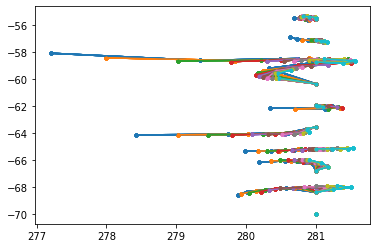

In [34]:
plt.plot(output['lon'].transpose(),output['lat'].transpose(),'.-');

In [ ]:
fig,ax = plt.subplots()
ax.plot(output['z'].transpose(),'.-');

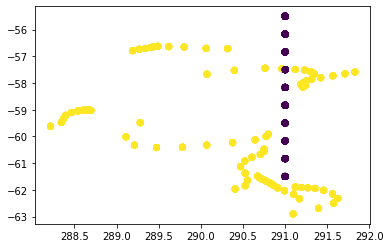

In [28]:
plt.scatter(output['lon'],output['lat'],c=output['S'])


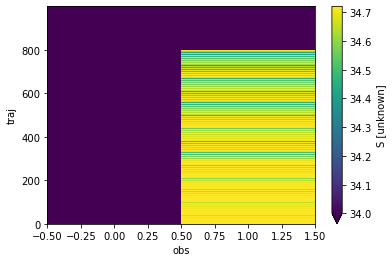

In [31]:
output['S'].plot(vmin=34)

In [42]:
lons.shape

(50, 50, 50)